# Fine-Tuning LLMs

### Step 1 - Set up the project environment
Storing secret keys in an .env file is a vital security practice, bolstering data protection and
mitigating risks.

In [1]:
# !pip install openai==1.55.3 httpx==0.27.2 python-dotenv pandas matplotlib

Importing modules

In [1]:
import pandas as pd
import os, time
from openai import OpenAI
import openai
from dotenv import load_dotenv
import json
import matplotlib.pyplot as plt

print("Modules are imported.")

Modules are imported.


Setting up the OpenAI API:

* Prepare a .env file to store the OpenAI API key.
* Uploading the .env file to our colab environment
* Load the API key and setup the API

In [2]:
load_dotenv('apikey.env.txt')
APIKEY = os.getenv('APIKEY')
ORGID=os.getenv('ORGID')

Creating OpenAI Client

In [3]:
client = OpenAI(
    api_key=APIKEY,
    organization=ORGID
)

### Step 2 - Prepare the training data

Loading the provided `Customer Complaints.csv`



In [5]:
training_data = pd.read_csv("Customer Complaints.csv")

In [6]:
training_data.head(3)

,Complaints,Details
0,Unreliable internet! Sick of constant outages...,"{""Topic"": ""Internet"", ""Problem"": ""Unreliable s..."
1,TV signal keeps dropping during crucial momen...,"{""Topic"": ""TV"", ""Problem"": ""Signal dropout"", ""..."
2,Phone line always crackling! Can't hear a thi...,"{""Topic"": ""Phone"", ""Problem"": ""Crackling line""..."


**Converting the Complaints records to json**

To be able to use the data for the fine-tuning purpose, we first need to convert each row of the dataframe into the following format:

<pre>
<code>
{
  <span style="color: blue;">"messages"</span>: [
    {
      <span style="color: blue;">"role"</span>: <span style="color: red;">"system"</span>,
      <span style="color: blue;">"content"</span>: "<span style="color: green;">Providing context about the user's prompt.
                  It may include information about the task,
                  instructions, or background details relevant
                  to the conversation.</span>"
    },
    {
      <span style="color: blue;">"role"</span>: <span style="color: red;">"user"</span>,
      <span style="color: blue;">"content"</span>: "<span style="color: green;">the prompt or input provided by the user,
                  which typically initiates the conversation with the assistant.</span>"
    },
    {
      <span style="color: blue;">"role"</span>: <span style="color: red;">"assistant"</span>,
      <span style="color: blue;">"content"</span>: "<span style="color: green;">The desired response or output generated by
                  the assistant in response to the user's prompt.</span>"
    }
  ]
}
</code>
</pre>

Define a method that get's a row of the dataframe and convert it into the json format

In [7]:
def save_as_json(row):

  system_content = """
      Given a customer complaint text, extract and return the following information in json (dict) format:
      - Topic: The product/department that the customer has a complaint about.
      - Problem: A two or three-word description of what exactly the problem is.
      - Customer_Dissatisfaction_Index: is a number between 0 and 100 showing
             how angry the customer is about the problem.
  """

  formatted_data = {
        "messages": [
            {"role": "system", "content": system_content},
            {"role": "user", "content": row.Complaints},
            {"role": "assistant", "content": row.Details}
        ]
      }

  with open("training_data.jsonl", "a") as json_file:
        json.dump(formatted_data, json_file)
        json_file.write("\n")

In [14]:
training_data[0:2]

,Complaints,Details
0,Unreliable internet! Sick of constant outages...,"{""Topic"": ""Internet"", ""Problem"": ""Unreliable s..."
1,TV signal keeps dropping during crucial momen...,"{""Topic"": ""TV"", ""Problem"": ""Signal dropout"", ""..."


Generate the `training_data.json`

In [15]:
for index, row in training_data.iterrows():
    save_as_json(row)

### Step 3 - Fine-tune GPT 3.5 based on our training data

- At a high level, fine-tuning consists of the following steps:
  1. Prepare and upload training data.
  2. Train a new fine-tuned model.
  3. Evaluate results and return to step 1 if necessary.
  4. Utilize your fine-tuned model.
- Fine-tuning beats few-shot learning with more training data, improving task
performance while reducing costs and enabling faster, more accurate
responses.
- You can adjust hyperparameters while fine-tuning your model, such as batch
size; learning rate multiplier; and number of epochs (n_epochs).

Import the json file we prepared as our training data

In [16]:
data_file = client.files.create(
    file=open('training_data.jsonl', 'rb'),
    purpose='fine-tune',
)
data_file

FileObject(id='file-DrxUhHfmPNEaqf6NHdxcaA', bytes=46789, created_at=1741649683, filename='training_data.jsonl', object='file', purpose='fine-tune', status='processed', status_details=None, expires_at=None)

Create the Fine Tuning Job

In [17]:
fine_tuning_job = client.fine_tuning.jobs.create(
    training_file=data_file.id,
    #model='deepseek-chat',
    model='gpt-3.5-turbo',
    hyperparameters={
        "n_epochs": 1
    }
)
fine_tuning_job

FineTuningJob(id='ftjob-4dnI87wWzMFsuVlsQa4t05BS', created_at=1741649729, error=Error(code=None, message=None, param=None), fine_tuned_model=None, finished_at=None, hyperparameters=Hyperparameters(n_epochs=1, batch_size='auto', learning_rate_multiplier='auto'), model='gpt-3.5-turbo-0125', object='fine_tuning.job', organization_id='org-OrtlKLkF3b4Imbi2nFy8S4VA', result_files=[], seed=1843516666, status='validating_files', trained_tokens=None, training_file='file-DrxUhHfmPNEaqf6NHdxcaA', validation_file=None, estimated_finish=None, integrations=[], user_provided_suffix=None, metadata=None, method={'type': 'supervised', 'supervised': {'hyperparameters': {'batch_size': 'auto', 'learning_rate_multiplier': 'auto', 'n_epochs': 1}}})

Let's retrieve the state of the fine-tune

In [18]:
client.fine_tuning.jobs.retrieve(fine_tuning_job.id).status

'validating_files'

In [19]:
while True:
    time.sleep(10)
    retrieved_job = client.fine_tuning.jobs.retrieve(fine_tuning_job.id)
    status = retrieved_job.status
    print(status)
    
    if status=="succeeded":
        print('done')
        break

running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
succeeded
done


In [25]:
retrieved_job

FineTuningJob(id='ftjob-4dnI87wWzMFsuVlsQa4t05BS', created_at=1741649729, error=Error(code=None, message=None, param=None), fine_tuned_model='ft:gpt-3.5-turbo-0125:personal::B9h1UaCR', finished_at=1741650030, hyperparameters=Hyperparameters(n_epochs=1, batch_size=1, learning_rate_multiplier=2), model='gpt-3.5-turbo-0125', object='fine_tuning.job', organization_id='org-OrtlKLkF3b4Imbi2nFy8S4VA', result_files=['file-C1Q9gH7uqW8WRHiQ9V7wf8'], seed=1843516666, status='succeeded', trained_tokens=9052, training_file='file-DrxUhHfmPNEaqf6NHdxcaA', validation_file=None, estimated_finish=None, integrations=[], user_provided_suffix=None, metadata=None, method={'type': 'supervised', 'supervised': {'hyperparameters': {'n_epochs': 1, 'batch_size': 1, 'learning_rate_multiplier': 2.0}}})

### Step 4 - Evaluate model

Retrieve the event messages to check out the learning process of our fine-tuning job.

In [21]:
client.fine_tuning.jobs.list_events(fine_tuning_job_id=retrieved_job.id, limit=100).data

[FineTuningJobEvent(id='ftevent-6sOT47ODmM1rj6crdgvxASlT', created_at=1741650037, level='info', message='The job has successfully completed', object='fine_tuning.job.event', data={}, type='message'),
 FineTuningJobEvent(id='ftevent-pwZ6dhKgRhsNf5gW4N8sbNqh', created_at=1741650032, level='info', message='New fine-tuned model created', object='fine_tuning.job.event', data={}, type='message'),
 FineTuningJobEvent(id='ftevent-E6imynxpgPR9XMJ1DXh3SU87', created_at=1741650004, level='info', message='Step 67/67: training loss=0.22', object='fine_tuning.job.event', data={'step': 67, 'train_loss': 0.22171585261821747, 'total_steps': 67, 'train_mean_token_accuracy': 0.8888888955116272}, type='metrics'),
 FineTuningJobEvent(id='ftevent-Ln4rRx1U15E1nEIKLwwwP4ai', created_at=1741650002, level='info', message='Step 66/67: training loss=0.11', object='fine_tuning.job.event', data={'step': 66, 'train_loss': 0.10901905596256256, 'total_steps': 67, 'train_mean_token_accuracy': 0.9615384340286255}, type=

In [22]:
events = list(client.fine_tuning.jobs.list_events(fine_tuning_job_id=retrieved_job.id, limit=100).data)

for e in events:
    print(e.message)

The job has successfully completed
New fine-tuned model created
Step 67/67: training loss=0.22
Step 66/67: training loss=0.11
Step 65/67: training loss=0.42
Step 64/67: training loss=0.05
Step 63/67: training loss=0.09
Step 62/67: training loss=0.64
Step 61/67: training loss=0.45
Step 60/67: training loss=0.06
Step 59/67: training loss=0.12
Step 58/67: training loss=0.13
Step 57/67: training loss=0.81
Step 56/67: training loss=0.11
Step 55/67: training loss=0.38
Step 54/67: training loss=0.13
Step 53/67: training loss=0.37
Step 52/67: training loss=0.09
Step 51/67: training loss=0.08
Step 50/67: training loss=0.08
Step 49/67: training loss=0.05
Step 48/67: training loss=0.13
Step 47/67: training loss=0.27
Step 46/67: training loss=0.11
Step 45/67: training loss=0.06
Step 44/67: training loss=0.22
Step 43/67: training loss=0.13
Step 42/67: training loss=0.11
Step 41/67: training loss=0.68
Step 40/67: training loss=0.23
Step 39/67: training loss=0.22
Step 38/67: training loss=0.77
Step 3

Let's extract the training loss in each learning step

In [ ]:
# data={'step': 66, 'train_loss': 0.10901905596256256, 'total_steps': 67, 'train_mean_token_accuracy': 0.9615384340286255}

In [23]:
steps = []
train_loss =[]

for e in events:
    if e.data:
        steps.append(e.data['step'])
        train_loss.append(e.data['train_loss'])
        
print(steps)
print(train_loss)

[67, 66, 65, 64, 63, 62, 61, 60, 59, 58, 57, 56, 55, 54, 53, 52, 51, 50, 49, 48, 47, 46, 45, 44, 43, 42, 41, 40, 39, 38, 37, 36, 35, 34, 33, 32, 31, 30, 29, 28, 27, 26, 25, 24, 23, 22, 21, 20, 19, 18, 17, 16, 15, 14, 13, 12, 11, 10, 9, 8, 7, 6, 5, 4, 3, 2, 1]
[0.22171585261821747, 0.10901905596256256, 0.42156946659088135, 0.05363185703754425, 0.09145304560661316, 0.6434953212738037, 0.45153120160102844, 0.06292877346277237, 0.11793197691440582, 0.12779346108436584, 0.8093974590301514, 0.11169794201850891, 0.3817248046398163, 0.12810198962688446, 0.37394827604293823, 0.086448535323143, 0.08142852783203125, 0.08169320970773697, 0.05177055299282074, 0.1342758983373642, 0.2667616307735443, 0.10984703153371811, 0.05634551867842674, 0.22218391299247742, 0.1346958726644516, 0.10966866463422775, 0.6799355149269104, 0.22782383859157562, 0.21639864146709442, 0.7724043726921082, 0.8367417454719543, 0.11226879805326462, 0.3176303207874298, 0.17569801211357117, 0.05844474956393242, 0.96861982345581

Use a line chart to visualize the train_loss in each step

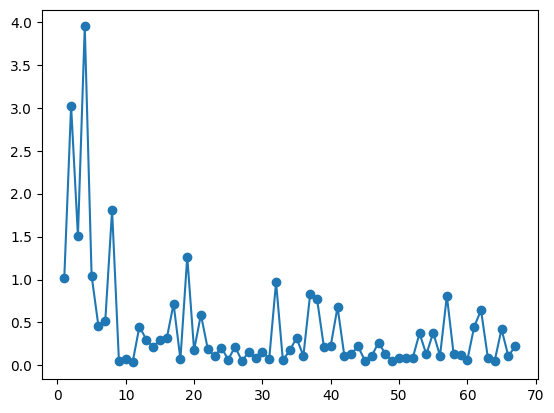

In [24]:
plt.plot(steps, train_loss, marker='o', linestyle='-')

### Step 5 - Deploy our model

Let's take a look at `retrieved_job` again

In [27]:
myLLM = retrieved_job.fine_tuned_model

Defining a method to extract information from a given user complaint using a specific LLM and return the results.

In [5]:
def extract_details(user_complaint, model_name):
    """
    This function extracts information from a given user complaint using a specific LLM (Large Language Model).

    Parameters:
    user_complaint (str): The text of the user's complaint.
    model_name (str): The name of the specific LLM model to use for extraction.
    """

    system_content = """
        Given a customer complaint text, extract and return the following information in JSON (dict) format:
        - Topic
        - Problem
        - Customer_Dissatisfaction_Index
    """

    # Generate a response using the specified model and the user's complaint
    response = client.chat.completions.create(
        model = model_name,
        messages=[
            {"role": "system", "content": system_content},  # System content explaining the expected output
            {"role": "user", "content": user_complaint}  # User's complaint passed as content
        ]
    )

    # Return the content of the generated response
    return response.choices[0].message.content


Use our fine-tuned model to extract the details for the following user complaint:

*TV channels keep disappearing from my subscription! What's going on? Extremely annoyed with this service!*

In [6]:
complaint = "TV channels keep disappearing from my subscription! what is going on? Extremely annoyed with this service!"
extract_details(complaint, myLLM)

'{"Topic": "TV", "Problem": "Channels Disappearing", "Customer_Dissatisfaction_Index": "High"}'

Let's test our `GPT-4` model with the same user complaint

In [7]:
extract_details(complaint, 'gpt-4')

'{\n  "Topic": "TV Service",\n  "Problem": "TV channels disappearing from subscription",\n  "Customer_Dissatisfaction_Index": "High"\n}'

We can see that our model, which is trained on our dataset, provides better answers compared to GPT-4. Our model is fine-tuned based on our data and is familiar with the different edge cases and the context of our dataset.

In [ ]:
customer_complaint = "I am very Angry! I want my money back!"
extract_details(customer_complaint, myLLM)